### Import

In [1]:
# configure paths for proper import 
import sys
import os
file_dir = os.getcwd()
package_dir = os.path.split(os.path.split(file_dir)[0])[0]
sys.path.insert(0, package_dir)

#file_directory = os.path.dirname(os.path.abspath(__file__))
#parent_directory = os.path.split(file_directory)[0]

# Data file
output_dir = package_dir + "/blip_wrapper"

In [2]:
import numpy as np
import torch
import time
import pandas as pd

import copy
import json

import matplotlib.pyplot as plt

import deblending_runjingdev.simulated_datasets_lib as simulated_datasets_lib
import deblending_runjingdev.sdss_dataset_lib as sdss_dataset_lib
import deblending_runjingdev.starnet_lib as starnet_lib
import deblending_runjingdev.sleep_lib as sleep_lib
import deblending_runjingdev.image_statistics_lib as image_statistics_lib
import deblending_runjingdev.daophot_catalog_lib as daophot_catalog_lib

import deblending_runjingdev.plotting_utils as plotting_utils

from deblending_runjingdev.which_device import device

np.random.seed(34534)
_ = torch.manual_seed(94219)

In [3]:
blip_dir = os.path.split(os.path.split(package_dir)[0])[0] + "/pyblip"
sys.path.insert(0, blip_dir)
import pyblip

hpt_dir = os.path.split(blip_dir)[0] + '/hpt/'
sys.path.insert(0, hpt_dir)
from hpt.utilities import elapsed
import networkx as nx

In [4]:
# Blip-wrappers
import performance_eval as pe

### 0. Load SDSS data

In [5]:
sdss_image, sdss_background, hubble_locs, hubble_fluxes, sdss_data, wcs = \
    sdss_dataset_lib.load_m2_data()

loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits
loading sdss image from ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits
loading hubble data from  ../hubble_data/hlsp_acsggct_hst_acs-wfc_ngc7089_r.rdviq.cal.adj.zpt
getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-r-002583-2-0136.fits

 aligning images. 
 Getting sdss coordinates from:  ../../sdss_stage_dir/2583/2/136/frame-i-002583-2-0136.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]



 returning image at x0 = 630, x1 = 310


In [6]:
nelec_per_nmgy = sdss_data[0]['nelec_per_nmgy'][0].mean()

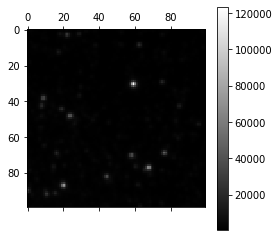

In [7]:
# the subimage of M2 considered in our paper
plt.matshow(sdss_image[0].cpu(), cmap = plt.cm.gray)
plt.colorbar()

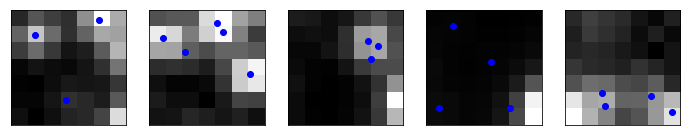

In [8]:
# a few example patches. 
# blue are hubble locations

f, axarr = plt.subplots(1, 5, figsize=(12, 6))

for i in range(5): 
    plotting_utils.plot_subimage(axarr[i], 
                                 sdss_image[0],
                                 None, 
                                 hubble_locs, 
                                 x0 = int(np.random.choice(100, 1)), 
                                 x1 = int(np.random.choice(100, 1)), 
                                 patch_slen = 7)
    axarr[i].set_xticks([]);
    axarr[i].set_yticks([]);
    


### 1. Load StarNet fit

In [9]:
# wake-sleep encoder
star_encoder_ws = starnet_lib.StarEncoder(slen = 100,
                                            ptile_slen = 8,
                                            step = 2,
                                            edge_padding = 3, 
                                            n_bands = 2,
                                            max_detections = 2)

star_encoder_ws.load_state_dict(torch.load('../fits/starnet-encoder-iter2', 
                               map_location=lambda storage, loc: storage))


star_encoder_ws.eval(); 
star_encoder_ws.to(device);

starnet_ws_map_locs, starnet_ws_map_fluxes, starnet_ws_map_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                    return_map_n_stars = True, 
                                    return_map_star_params = True)[0:3]

# Sample from the posterior
n_starnet_samples = 10000
starnet_ws_locs, starnet_ws_fluxes, starnet_ws_map_n_stars = \
    star_encoder_ws.sample_star_encoder(sdss_image.unsqueeze(0).to(device), 
                                        n_samples=n_starnet_samples,
                                        return_map_n_stars = False, 
                                        return_map_star_params = False
                                       )[0:3]
starnet_ws_locs = starnet_ws_locs[0::10]

### 2. Analysis start to finish


In [10]:
hub_loc = hubble_locs.numpy()
hub_flux = hubble_fluxes[:, 0].numpy()

In [11]:
slen = 100
blip_out = dict()
qs = np.arange(1, 16) / 20
grid_sizes = np.around(np.logspace(np.log10(50), 4, 25))
print("The number of candidate groups is", int(np.sum(grid_sizes**2)))

The number of candidate groups is 280154453


In [12]:
def cg_to_dict(cg):
    """ For saving cand groups """
    out = dict()
    out['group'] = list(cg.group)
    out['pep'] = cg.pep
    for key in cg.data:
        if key == 'blip-group':
            continue
        if isinstance(cg.data[key], set):
            out[key] = list(cg.data[key])
        elif isinstance(cg.data[key], np.float32):
            out[key] = float(cg.data[key])
        else:
            out[key] = cg.data[key]
    return out


In [13]:
recompute_cand_groups = False
max_pep = 0.75

if recompute_cand_groups:
    peps = pyblip.create_groups_cts.grid_peps(
        starnet_ws_locs.numpy(),
        grid_sizes,
        extra_centers=starnet_ws_map_locs.numpy()[0],
        max_pep=max_pep,
        log_interval=10, 
        shape='circle',
        count_signals=True,
    )
    all_cgs = dict()
    for count_signals in [True, False]:
        if count_signals:
            input_peps = peps
        else:
            input_peps = {}
            for key in peps.keys():
                input_peps[key] = 1 - peps[key]['pip']
        
        # Create cand groups
        all_cand_groups, _ = pyblip.create_groups_cts.grid_peps_to_cand_groups(
            input_peps, 
            max_blip_size=5000, 
            shape='circle', 
            verbose=True,
            max_pep=max_pep,
        )
        # Save
        cgs_saveable = [[] for j in range(len(all_cand_groups))]
        for j, cgs in enumerate(all_cand_groups):
            cgs_saveable[j].extend(
                [cg_to_dict(x) for x in cgs]
            )
        all_cgs[int(count_signals)] = cgs_saveable
        with open(f"{output_dir}/m2_cand_groups.json", 'w') as file:
            file.write(json.dumps(all_cgs))
    
# Load cached cand_groups
with open(f"{output_dir}/m2_cand_groups.json", 'r') as file:
    all_cand_groups_cached = json.load(file)

all_cand_groups_dict = dict()
for count_signals in [0, 1]:
    all_cand_groups = [[] for _ in range(len(
        all_cand_groups_cached[str(count_signals)]
    ))]
    for j, cgs in enumerate(all_cand_groups_cached[str(count_signals)]):
        for data_dict in cgs:
            all_cand_groups[j].append(
                pyblip.create_groups.CandidateGroup(
                    group=data_dict['group'],
                    pep=data_dict['pep'],
                    data=data_dict
                )
            )
    all_cand_groups_dict[count_signals] = all_cand_groups

In [14]:
# Weight functions
from pyblip.weight_fns import inverse_radius_weight as inv_rad_weight

# Create a few weight functions
def softmax_inv_radius(cg, t=0.01):
    exprad = np.exp(t / cg.data['radius'])
    if exprad > 1e10:
        return 1
    return exprad / (1.0 + exprad)
    
def const_weight(cg):
    return 1.0

def inv_ci(cg):
    return 1 / len(cg.data['nsignals'])

weight_fn_dict = {
    #"const (fixed res)":const_weight,
    #"soft_inv_rad":softmax_inv_radius,
    "inv_rad":inv_rad_weight,
    #"const":const_weight,
}

In [16]:
recompute_blip = False

if recompute_blip:

    time0 = time.time()
    blip_out = dict()

    for count_signals, weight_fn in zip(
        [False, True], 
        [inv_rad_weight, inv_ci]
    ):
        blip_out[int(count_signals)] = dict()

        # Run pyblip to control FDR
        for q in qs:
            all_rej = []
            print(f"At q={q}, count_signals={count_signals}, at {elapsed(time0)}.")
            for cand_groups in all_cand_groups_dict[int(count_signals)]:
                cgs = [copy.deepcopy(n) for n in cand_groups]
                rej = pyblip.blip.BLiP(
                    cand_groups=cgs,
                    weight_fn=weight_fn,
                    max_pep=max(2*q, 0.5),
                    error='fdr',
                    q=q,
                    verbose=True,
                    deterministic=False,
                )
                all_rej.extend(rej)

            blip_out[int(count_signals)][q] = all_rej

    # Make sure output is hashable
    blip_out_saveable = dict()
    for key in blip_out:
        blip_out_saveable[key] = {q:[] for q in blip_out[key].keys()}
        for q in blip_out[key]:
            blip_out_saveable[key][q] = [cg_to_dict(x) for x in blip_out[key][q]]
    # Save output and cand_groups
    with open(f"{output_dir}/m2_blip_output.json", 'w') as file:
        file.write(json.dumps(blip_out_saveable))
        
# Load output
with open(f"{output_dir}/m2_blip_output.json", 'r') as file:
    blip_out_read = json.load(file)

# Turn into nodes
def try_float(x):
    try:
        return np.around(float(x), 4)
    except:
        return x
    
# Turn into nodes
blip_out = dict()
for weight_fn_name in blip_out_read.keys():
    blip_out[weight_fn_name] = {try_float(q):[] for q in blip_out_read[weight_fn_name].keys()}
    for q in blip_out_read[weight_fn_name]:
        for data_dict in blip_out_read[weight_fn_name][q]:
            blip_out[weight_fn_name][try_float(q)].append(
                pyblip.create_groups.CandidateGroup(
                    group=data_dict['group'],
                    pep=data_dict['pep'],
                    data=data_dict
                )
            )

### 3. Performance Evaluation

### 3(a) Evaluation for BLiP

In [17]:
global_slack = 0.01

In [18]:
blip_power_outputs = []
all_estimators = []
power_cols = ['method', 'count_signals', 'q', 'power', 'fdr', 'res_power', 'fixed_radius']
estimator_columns = [
    'method', 'method2', 'x', 'y', 'radius', 'true_disc', 'min_dist'
]

for count_signals in blip_out.keys():
    for q in blip_out[count_signals].keys():
        # Calculate power + FDR for blip output
        locs_est, locs_error, locs_peps, weights = pe.blip_output_to_catalogue(
            blip_out[count_signals][q]
        )
        # Create nsignal ci if we are counting signals
        if count_signals == '1':
            nsignal_ci = [x.data['nsignals'] for x in blip_out[count_signals][q]]
        else:
            nsignal_ci = None
            
        power, fdr, res_power, ppv_bool = pe.catalogue_power_fdr(
            locs_true=hub_loc,
            locs_est=locs_est,
            locs_error=locs_error,
            weights=weights,
            slen=slen,
            pad=0,
            slack=global_slack,
            return_bools=True,
            nsignal_ci=nsignal_ci,
        )
        blip_power_outputs.append([
            'Starnet + BLiP', count_signals, q, power, fdr, res_power, 0
        ])

        # Calculate distance-based metric
        d = hub_loc.shape[1]
        m = hub_loc.shape[0]
        n = locs_est.shape[0]

        # Save estimators
        if int(count_signals) == 0:
            est_df = pd.DataFrame(columns=estimator_columns)
            est_df['y'] = locs_est[:, 0]
            est_df['x'] = locs_est[:, 1]
            est_df['radius'] = locs_error
            est_df['true_disc'] = ppv_bool
            est_df['method'] = 'Starnet + BLiP'
            est_df['method2'] = f'BLiP (q={q})'
            all_estimators.append(est_df)

/home/asher/Documents/Research/Knockoff/adaptive2/pcat-rep/DeblendingStarfields/blip_wrapper/performance_eval.py:267: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif weights == 'const':


### 3(b) Evaluation of power for MAP

In [20]:
# Performance evaluation for map estimation with different slack parameters
fixed_radii = [1/1600, 1/1200, 1/800, 1/600, 1/400, 1/300, 1/200, 1/150, 1/100, 1/50,]
map_ests = starnet_ws_map_locs.numpy()[0]
map_power_outputs = []

for count_signals in [True, False]:
    for radius in fixed_radii:
        nsignal_ci = [set([1]) for _ in range(len(map_ests))] if count_signals else None
        power, fdr, res_power = pe.catalogue_power_fdr(
            locs_true=hub_loc,
            locs_est=map_ests,
            locs_error=radius * np.ones(map_ests.shape[0]),
            nsignal_ci=nsignal_ci,
            slen=slen,
            pad=0,
            slack=global_slack
        )
        map_power_outputs.append([
            'Starnet (MAP)', count_signals, 1, power, fdr, res_power, radius
        ])


In [21]:
power_outputs = map_power_outputs + blip_power_outputs
pdf = pd.DataFrame(power_outputs, columns=power_cols)
pdf['count_signals'] = pdf['count_signals'].astype(int)
pdf.to_csv(f"{output_dir}/m2_power_v2.csv", index=False)

### 3(c), dataframe of the output for MAP and then save

In [22]:
# Distance from points to sources for map estimates
m = hub_loc.shape[0]
n = map_ests.shape[0]
min_dists = np.abs(
    hub_loc.reshape(m, 1, 2) - map_ests.reshape(1, n, 2)
).max(axis=2).min(axis=0)
# map_dist_df = pd.DataFrame(columns=dist_cols)
# map_dist_df['dist'] = min_dists
# map_dist_df['method'] = 'Starnet (MAP)'
# map_dist_df['q'] = np.nan

In [23]:
# Dataframe of estimators for map
other_est_dfs = []
for count_signals in [False]:
    for locs, true_disc, method, method2, mdists in zip(
        [map_ests, hub_loc], 
        [min_dists <= 0.005, 1],
        ['Starnet (MAP)', 'Hubble'],
        ['MAP', 'Hubble'],
        [min_dists, 0]
    ):
        est_df = pd.DataFrame(columns=estimator_columns)
        est_df['y'] = locs[:, 0]
        est_df['x'] = locs[:, 1]
        est_df['radius'] = 0
        est_df['true_disc'] = true_disc
        #est_df['count_signals'] = count_signals
        est_df['method'] = method
        est_df['method2'] = method2
        est_df['min_dist'] = mdists
        other_est_dfs.append(est_df)

In [26]:
all_ests = pd.concat(all_estimators + other_est_dfs, axis='index')
all_ests.to_csv(f"{output_dir}/m2_ests_v2.csv", index=False)

### Explore samples

In [24]:
def get_rect_flags(data, lx, ux, ly, uy):
    """
    Subset data to just look at a specific rectangle
    """
    flags = (data[:, 0] >= lx)
    flags = flags & (data[:, 1] >= ly)
    flags = flags & (data[:, 0] <= ux)
    flags = flags & (data[:, 1] <= uy)
    return flags

In [25]:
def locs_to_hist_inputs(samples, nbins):
    """ No double counting per square """
    N1, N2, d = samples.shape
    output = []
    for i in range(N1):
        subset = samples[i]
        subset = subset[np.any(subset != 0, axis=-1)]
        corners = np.floor(subset * nbins)
        corners = corners.astype(float) / nbins
        centers = corners + 1 / (2 * nbins)
        output.append(np.unique(centers, axis=0))
    return np.concatenate(output, axis=0)
        

In [30]:
import plotly.graph_objects as go
import plotly.express as px

lv = 0.4
uv = 0.6
nbins = 50

snet_locs = locs_to_hist_inputs(
    starnet_ws_locs.numpy().copy(), nbins=int(nbins / (uv - lv))
)
map_locs = map_ests.reshape(-1, 2)

flags = get_rect_flags(snet_locs, lv, uv, lv, uv)
map_flags = get_rect_flags(map_locs, lv, uv, lv, uv)
hub_flags = get_rect_flags(hub_loc, lv, uv, lv, uv)

fig = px.density_heatmap(
    x=snet_locs[flags, 1], 
    y=snet_locs[flags, 0],
    color_continuous_scale='blues', # also 'cividis'
    height=800,
    width=800,
    nbinsx=nbins,
    nbinsy=nbins,
)
fig.add_trace(go.Scatter(
    x=map_locs[map_flags, 1], 
    y=map_locs[map_flags, 0],
    showlegend=False,
    mode='markers',
    marker=dict(
        symbol='x',
        opacity=0.5,
        color='red'
    )
))
fig.add_trace(go.Scatter(
    x=hub_loc[hub_flags, 1], 
    y=hub_loc[hub_flags, 0],
    showlegend=False,
    mode='markers',
    marker=dict(
        symbol='x',
        opacity=0.5,
        color='black'
    )
))

# Add discoveries
for cg in blip_out['0'][0.05]:
    if cg.data['dim0'] <= uv and cg.data['dim0'] >= lv:
        if cg.data['dim1'] <= uv and cg.data['dim1'] >= lv:
            if True:#cg.pep < 0.5 and cg.pep > 0.2:
                fig.add_shape(type='circle',
                    xref='x', yref='y',
                    x0=cg.data['dim1'] - cg.data['radius'],
                    y0=cg.data['dim0'] - cg.data['radius'],
                    x1=cg.data['dim1'] + cg.data['radius'],
                    y1=cg.data['dim0'] + cg.data['radius'],
                    line_color='black',
                )  
                
    
#fig.show()

### Debugging

In [32]:
fig = px.density_heatmap(
    x=snet_locs[flags, 1], 
    y=snet_locs[flags, 0],
    color_continuous_scale='blues',
    height=800,
    width=800,
    nbinsx=nbins,
    nbinsy=nbins,
)
#fig.show()